In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
#!pip install tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA IMPORT

In [ ]:
import tensorflow as tf

In [ ]:

file="all-data.csv"

# Detect encoding
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.73, 'encoding': 'Windows-1252', 'language': ''}

In [ ]:
df=pd.read_csv(file,encoding='Windows-1252',header=None)

In [ ]:
df.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
mycolumns = ['Sentiment','Sentence']

df.columns=mycolumns

In [ ]:
pf=df[['Sentence','Sentiment']]

In [ ]:
pf.head()

,Sentence,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


# DATA PREPARATION

In [ ]:
 pf['Sentence']=pf["Sentence"].str.lower()

In [ ]:
pf['Sentiments'] = pf['Sentiment'].map({'neutral':0,'positive':1,'negative':-1})

# TF-IDF IMPLEMENTATION

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

analyze = vectorizer.build_analyzer()

In [ ]:
vectorizer.fit(pf["Sentence"])

features=vectorizer.transform(pf["Sentence"])

final=pd.DataFrame(features.todense(), columns = vectorizer.get_feature_names())

final['Sentiment']=pf['Sentiments']

In [ ]:
final.head()

,00,000,000063,002,0025,003,0030,007,008,01,0101138,012,0187274,019,02,023,027,029,03,030,031,035,04,045,046,047,0491,05,050,052,06,060,063,064,067,07,070,0711,0762,08,...,zao,zapadnye,zealand,zepro,zero,zgody,zinc,zip,zloty,zoltan,zone,zoo,zte,zu,æhikauppa,æhivakuutus,æinen,æjoki,ækel,æki,æl,æliitto,ælt,æmeri,æn,ænekoski,ænen,ænge,ænnen,ænsi,ærnits,ærtsil,ærvi,ærvinen,æsein,æskyl,ætehuolto,ðl,ˆeur,Sentiment
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.147059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
final.describe()

,00,000,000063,002,0025,003,0030,007,008,01,0101138,012,0187274,019,02,023,027,029,03,030,031,035,04,045,046,047,0491,05,050,052,06,060,063,064,067,07,070,0711,0762,08,...,zao,zapadnye,zealand,zepro,zero,zgody,zinc,zip,zloty,zoltan,zone,zoo,zte,zu,æhikauppa,æhivakuutus,æinen,æjoki,ækel,æki,æl,æliitto,ælt,æmeri,æn,ænekoski,ænen,ænge,ænnen,ænsi,ærnits,ærtsil,ærvi,ærvinen,æsein,æskyl,ætehuolto,ðl,ˆeur,Sentiment
count,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,...,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000
mean,0.001026,0.007455,0.000058,0.000074,0.000048,0.000050,0.000042,0.000095,0.000078,0.000613,0.000044,0.000206,0.000068,0.000095,0.000480,0.000060,0.000074,0.000056,0.000669,0.000049,0.000063,0.000045,0.000593,0.000183,0.000091,0.000070,0.000035,0.000462,0.000074,0.000063,0.000493,0.000108,0.000129,0.000055,0.000049,0.000467,0.000108,0.000055,0.000068,0.000427,...,0.000125,0.000055,0.000059,0.000059,0.000054,0.000062,0.000444,0.000113,0.000073,0.000045,0.000365,0.000048,0.000058,0.000043,0.000052,0.000048,0.000587,0.000060,0.000144,0.000173,0.000159,0.000043,0.000043,0.000057,0.000051,0.000209,0.000177,0.000150,0.000533,0.000067,0.000047,0.000238,0.000363,0.000104,0.000060,0.000057,0.000063,0.000095,0.000066,0.156624
std,0.015828,0.041798,0.004017,0.005170,0.003336,0.003453,0.002890,0.006592,0.005395,0.013120,0.003066,0.008330,0.004765,0.006592,0.012415,0.004165,0.005180,0.003917,0.015162,0.003381,0.004366,0.003109,0.014049,0.007521,0.006302,0.004873,0.002433,0.012788,0.005180,0.004366,0.012550,0.007486,0.006351,0.003820,0.003435,0.013567,0.007551,0.003843,0.004721,0.010775,...,0.006348,0.003851,0.004080,0.004080,0.003732,0.004339,0.012356,0.007879,0.005067,0.003123,0.009707,0.003347,0.004017,0.002967,0.003630,0.003372,0.012971,0.004152,0.007088,0.006955,0.008007,0.003021,0.002967,0.003977,0.003524,0.008411,0.007121,0.007413,0.012736,0.004681,0.003244,0.008483,0.010453,0.007254,0.004152,0.003980,0.004407,0.006622,0.004569,0.617616
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
final.Sentiment.sum()

759

#  Data Cleaning

In [ ]:
final = final.drop(final.columns[final.sum() < 0.5], axis=1)
#final['Sentiment'] = Doc[0]



# TEST - TRAIN SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X = final.drop('Sentiment',axis=1)
y = final['Sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# RANDOM FOREST IMPLEMENTATION AND TUNING

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score,mean_absolute_error,mean_squared_error


In [ ]:
test_error = []

for n in range(1,10):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features='auto')
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))
    print(accuracy_score(test_preds,y_test)*100)

62.88659793814433
62.06185567010309
63.092783505154635
71.1340206185567
68.45360824742268
70.72164948453609
70.10309278350515
71.95876288659794
69.89690721649484


In [ ]:
test_error = []

for n in range(1,10):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features='sqrt')
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))
    print(accuracy_score(test_preds,y_test)*100)

66.8041237113402
61.23711340206186
66.8041237113402
67.83505154639175
71.34020618556701
71.34020618556701
72.98969072164948
70.9278350515464
69.89690721649484


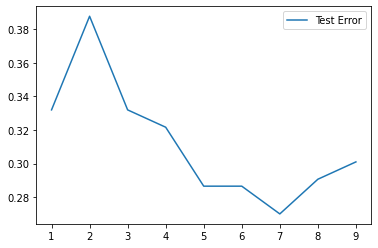

In [ ]:
plt.plot(range(1,10),test_error,label='Test Error')
plt.legend()

In [ ]:
model = RandomForestClassifier(n_estimators=9,max_features='auto',random_state=101)

model.fit(X_train,y_train)

pred_RF = model.predict(X_test)

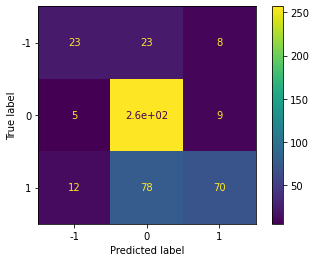

In [ ]:
plot_confusion_matrix(model,X_test,y_test)

#### MODEL TUNING

In [ ]:
from sklearn.model_selection import GridSearchCV        # takes much time to run on pc

n_estimators=[64,100,128,200]
max_features= ['auto','sqrt']


param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             }  

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid)

grid.fit(X_train,y_train)

grid.best_params_

# XGB IMPLEMENTATION

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.58%


# NEURAL NETWORK IMPLEMENTATION

In [ ]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
X_train_scaled = scaler.transform(X_train)

X_test_scaled  = scaler.transform(X_test)

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = 'adam',loss='mse')

model.fit(X_train_scaled,y_train,epochs=50,batch_size=256)

Epoch 1/50
18/18 [==============================] - 1s 11ms/step - loss: 0.3760
Epoch 2/50
18/18 [==============================] - 0s 12ms/step - loss: 0.3429
Epoch 3/50
18/18 [==============================] - 0s 10ms/step - loss: 0.3104
Epoch 4/50
18/18 [==============================] - 0s 11ms/step - loss: 0.2754
Epoch 5/50
18/18 [==============================] - 0s 11ms/step - loss: 0.2434
Epoch 6/50
18/18 [==============================] - 0s 10ms/step - loss: 0.2149
Epoch 7/50
18/18 [==============================] - 0s 11ms/step - loss: 0.1922
Epoch 8/50
18/18 [==============================] - 0s 11ms/step - loss: 0.1732
Epoch 9/50
18/18 [==============================] - 0s 11ms/step - loss: 0.1582
Epoch 10/50
18/18 [==============================] - 0s 10ms/step - loss: 0.1463
Epoch 11/50
18/18 [==============================] - 0s 10ms/step - loss: 0.1370
Epoch 12/50
18/18 [==============================] - 0s 10ms/step - loss: 0.1292
Epoch 13/50
18/18 [==================

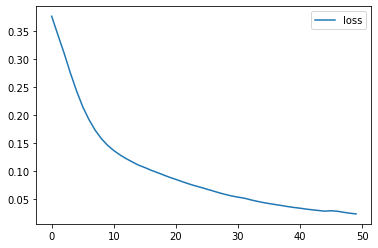

In [ ]:
loss= pd.DataFrame(model.history.history)
loss.plot()

In [ ]:
#model.evaluate(X_test_scaled,y_test,verbose=0)

pred_nn =model.predict(X_test_scaled)

#checking for errors



In [ ]:
mean_squared_error(y_test,pred_nn)

0.3709480906695036

## NEURAL NETWORKS AFTER  LABEL ENCODING

In [ ]:
## This is made seperate as we have used label encoding which is different than previous 3 models
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
all_labels = pf['Sentiment'].values

In [ ]:
all_inputs = X.values

In [ ]:
#all_labels

In [ ]:
#all_inputs

In [ ]:
encoder = LabelEncoder()
encoder.fit(all_labels)
encoded_Y = encoder.transform(all_labels)

dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=all_inputs.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(all_inputs,dummy_y, test_size=0.1, random_state=101)

In [ ]:
train_x = np.asarray(X_train_encoded)
train_y = np.asarray(y_train_encoded)
validation_x = np.asarray(X_test_encoded)
validation_y = np.asarray(y_test_encoded)

In [ ]:
model.fit(train_x,train_y, epochs=30)

Epoch 1/30
137/137 [==============================] - 1s 5ms/step - loss: 0.9780 - accuracy: 0.5923
Epoch 2/30
137/137 [==============================] - 1s 5ms/step - loss: 0.7164 - accuracy: 0.6421
Epoch 3/30
137/137 [==============================] - 1s 5ms/step - loss: 0.4982 - accuracy: 0.7707
Epoch 4/30
137/137 [==============================] - 1s 5ms/step - loss: 0.3279 - accuracy: 0.8737
Epoch 5/30
137/137 [==============================] - 1s 5ms/step - loss: 0.1651 - accuracy: 0.9594
Epoch 6/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0766 - accuracy: 0.9828
Epoch 7/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0431 - accuracy: 0.9895
Epoch 8/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0274 - accuracy: 0.9927
Epoch 9/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0201 - accuracy: 0.9954
Epoch 10/30
137/137 [==============================] - 1s 5ms/step - loss: 0.0158 - accuracy: 0.9959

In [ ]:
pred_train = model.predict(train_x)
scores = model.evaluate(train_x, train_y, verbose=0)
print('Accuracy on training data: {} \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(validation_x)
scores2 = model.evaluate(validation_x, validation_y, verbose=0)
print('Accuracy on test data: {} \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))   

Accuracy on training data: 0.9993121027946472 
 Error on training data: 0.0006878972053527832
Accuracy on test data: 0.7360824942588806 
 Error on test data: 0.2639175057411194


# Decision Trees


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth = 15).fit(X_train,y_train)
y_pred = dtree.predict(X_test)


In [ ]:
print(y_pred)

[ 0  0  0  0  0  0  0  0 -1  0  1 -1  0  0  0  0  0  0  0  1  1  0 -1  0
  0  0  1 -1  0  0  0  0  1  1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  1  1  0
 -1  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  0  1  1  0  0  0  1  0  1  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  1  1  0 -1  1  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  1  1
  0  0  1  1  0  1 -1  0 -1  0  0  0  0  0  0  1  1 -1 -1  0  0  0  0  0
  0  1  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  0  0  1  1  0  0  0
  1  0  1  0  0  0  0  0  1  0  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0
  0 -1 -1  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  1  0  1  0
  0  1  0  0  0  0  0  0  1  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  1
  0  0 -1  0  0  0  0  0  1  0  0  0  0  0 -1  0  1  0  0  1  0  1  0  0
  0  0  1  0  0  0  0  0  0  0  1  0 -1  0  1  0  0  0  0  0  0  1  0  0
  0  0  0  0  1  0  1  1  0  0  0  0  0  0  0  0  0

In [ ]:
count = 0
#for i in range(len(y_pred)):
 # if y_pred[i]==y_test[i]:
  #  count = count+1

        



  
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))      
#accuracy = count/len(y_pred)
#print('accuracy = ' ,accuracy*100 , '%')

Accuracy: 68.04%
